# Galaxy Classification, Anomaly Detection, Autoencoder & VAE (Keras)
This notebook uses the Galaxy10 DECaLS dataset (astronomical galaxy images) for:

1. Data loading & splitting, defining an anomaly class  
2. CNN classifier + ROC curves & confusion matrices  
3. Convolutional autoencoder for anomaly detection  
4. Variational autoencoder (VAE) + galaxy generation

Dataset: Galaxy10 DECaLS (HDF5).


In [1]:
!pip install -U 'tensorflow[and-cuda]'
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras import layers, ops, Model, random, models

import numpy as np
import h5py
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

## 1. Download the dataset, inspect classes, create anomaly split

Steps:
- Download `Galaxy10_DECals_64.h5`
- Load images and labels with `h5py`
- Inspect shape and class distribution
- Remove class 4 and store it as the anomaly dataset
- Split remaining (standard) data into train (50%), val (25%), test (25%)

In [2]:
# Download Galaxy10 DECaLS (HDF5)
! rm ./Galaxy10_DECals_64.h5
! wget https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
data_path = "./Galaxy10_DECals_64.h5"

print("Downloaded to:", data_path)


--2025-12-01 20:25:30--  https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 128.142.53.28, 128.142.170.17, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159140118 (152M) [application/octet-stream]
Saving to: ‘Galaxy10_DECals_64.h5’

Galaxy10_DECals_64. 100%[===================>] 151.77M  16.2MB/s    in 11s     

2025-12-01 20:25:42 (13.4 MB/s) - ‘Galaxy10_DECals_64.h5’ saved [159140118/159140118]

Downloaded to: ./Galaxy10_DECals_64.h5


In [ ]:
# Copy data onto drive s.t. dont need to download every time
from google.colab import drive
drive.mount('/content/drive')

import os
from pathlib import Path

# Pfade
drive_path = Path("/content/drive/MyDrive/Galaxy10_DECals_64.h5")
local_path = Path("./Galaxy10_DECals_64.h5")

#!cp "./Galaxy10_DECals_64.h5" "/content/drive/MyDrive/Galaxy10_DECals_64.h5"

# 1. case: data not on google drive
if not drive_path.exists():
    print("start download from cern...")
    !wget -O "{drive_path}" https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
    print("finished download from cern!")
else:
    print("dataset already on google drive")

# 2. case: data on google drive
if not local_path.exists():
    print("copy data from google drive into colab")
    !cp "{drive_path}" "{local_path}"
else:
    print("data already in colab")

# Endgültiger Pfad für den Rest deines Codes
data_path = "./Galaxy10_DECals_64.h5"
print(f"Data path: {data_path}")

In [3]:
# Load images and labels using h5py
with h5py.File(data_path, "r") as f:
    images = np.array(f["images"])   # shape (17736, 256, 256, 3)
    labels = np.array(f["ans"])      # shape (17736,)

#  normalize pixels in [0,1]
images = images/255

print("Images shape:", images.shape)
print("Labels shape:", labels.shape, "dtype:", labels.dtype)

Images shape: (17736, 64, 64, 3)
Labels shape: (17736,) dtype: uint8


In [4]:
# Class names from the Galaxy10 DECaLS documentation
class_names = {
    0: "Disturbed Galaxies",
    1: "Merging Galaxies",
    2: "Round Smooth Galaxies",
    3: "In-between Round Smooth Galaxies",
    4: "Cigar Shaped Smooth Galaxies",  # will be 'anomaly'
    5: "Barred Spiral Galaxies",
    6: "Unbarred Tight Spiral Galaxies",
    7: "Unbarred Loose Spiral Galaxies",
    8: "Edge-on Galaxies without Bulge",
    9: "Edge-on Galaxies with Bulge"
}

unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:")
for u, c in zip(unique, counts):
    print(f"Class {u} ({class_names[u]}): {c}")

Class distribution:
Class 0 (Disturbed Galaxies): 1081
Class 1 (Merging Galaxies): 1853
Class 2 (Round Smooth Galaxies): 2645
Class 3 (In-between Round Smooth Galaxies): 2027
Class 4 (Cigar Shaped Smooth Galaxies): 334
Class 5 (Barred Spiral Galaxies): 2043
Class 6 (Unbarred Tight Spiral Galaxies): 1829
Class 7 (Unbarred Loose Spiral Galaxies): 2628
Class 8 (Edge-on Galaxies without Bulge): 1423
Class 9 (Edge-on Galaxies with Bulge): 1873


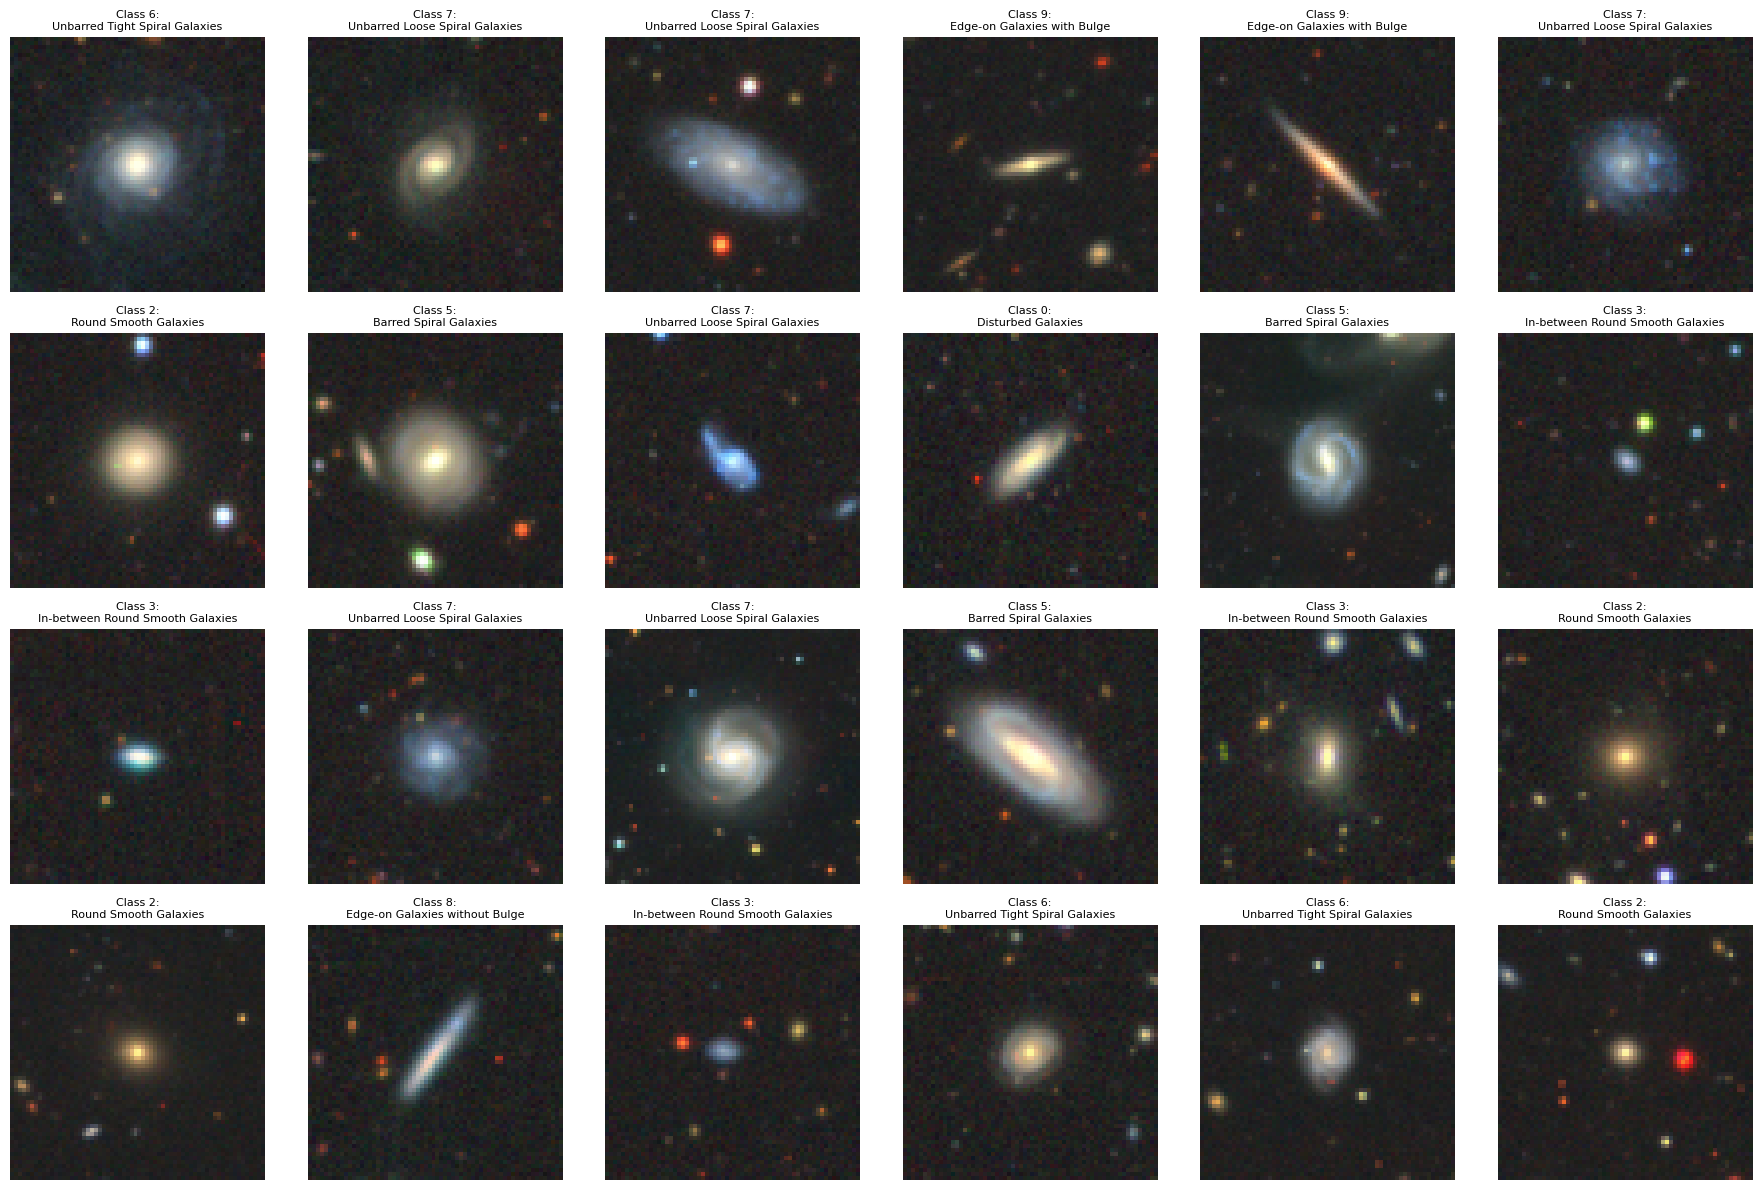

In [237]:
# Show a grid of sample images from different classes
def show_examples(images, labels, class_names, n_rows=4, n_cols=6):
    plt.figure(figsize=(3*n_cols, 3*n_rows))
    indices = np.random.choice(len(images), size=n_rows*n_cols, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(images[idx])
        plt.title(f"Class {labels[idx]}:\n{class_names[int(labels[idx])]}", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_examples(images, labels, class_names)

In [6]:
# Create anomaly dataset: all class 0 images
ANOMALY_CLASS = 0

anomaly_mask = (labels == ANOMALY_CLASS)
standard_mask = ~anomaly_mask

anom_images = images[anomaly_mask]
anom_labels = labels[anomaly_mask]  # all 0, but we keep them for bookkeeping

std_images = images[standard_mask]
std_labels_original = labels[standard_mask]

print("Standard images:", std_images.shape)
print("Anomaly images:", anom_images.shape)

Standard images: (16655, 64, 64, 3)
Anomaly images: (1081, 64, 64, 3)


In [7]:
# For training, remap standard labels from {0,1,2,3,5,6,7,8,9} -> {0,...,8}
unique_std_classes = sorted(np.unique(std_labels_original))
print("Standard classes (original indices):", unique_std_classes)

# Create mapping dict
label_map = {original: new for new, original in enumerate(unique_std_classes)}
inv_label_map = {v: k for k, v in label_map.items()}

print("Label map (original -> new):", label_map)

std_labels = np.vectorize(label_map.get)(std_labels_original)
print("Remapped standard labels min/max:", std_labels.min(), std_labels.max())
n_classes = len(unique_std_classes)

Standard classes (original indices): [1, 2, 3, 4, 5, 6, 7, 8, 9]
Label map (original -> new): {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8}
Remapped standard labels min/max: 0 8


In [8]:
# Split standard data: 50% train, 25% val, 25% test

# First split: train (50%) and temp (50%)
X_train_std, X_temp_std, y_train_std, y_temp_std = train_test_split(
    std_images,
    std_labels,
    test_size=0.5,
    stratify=std_labels,
    random_state=42
)

# Second split: temp into val (25%) and test (25%) of full standard data
X_val_std, X_test_std, y_val_std, y_test_std = train_test_split(
    X_temp_std,
    y_temp_std,
    test_size=0.5,
    stratify=y_temp_std,
    random_state=42
)

print("Train standard:", X_train_std.shape, y_train_std.shape)
print("Val standard:  ", X_val_std.shape, y_val_std.shape)
print("Test standard: ", X_test_std.shape, y_test_std.shape)
del std_images, std_labels, X_temp_std, y_temp_std

Train standard: (8327, 64, 64, 3) (8327,)
Val standard:   (4164, 64, 64, 3) (4164,)
Test standard:  (4164, 64, 64, 3) (4164,)


In [9]:
from keras.src.utils import to_categorical

# Convert labels into one-hot encoding
y_train_enc = to_categorical(y_train_std, 9)
y_val_enc = to_categorical(y_val_std, 9)
y_test_enc = to_categorical(y_test_std, 9)

print(y_train_enc[0])

[0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [10]:
# Plot training history (accuracy and loss)
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.legend()

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.legend()

    plt.show()

In [11]:
# Plot ROC Curve
def plot_roc_curve(X_test, y_test, model):
    y_pred_proba = model.predict(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(9):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(9):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.6f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [12]:
import seaborn as sns

# Confusion Matrix
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(9)), yticklabels=list(range(9)))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

## 2. CNN classifier + ROC curves + confusion matrices

Steps:
- Build a CNN classifier on the **standard** dataset (9 classes)
- Train on train set, validate on val set
- Plot training history (loss & accuracy)
- Compute ROC curves (one-vs-rest) on the standard test set
- Compute confusion matrix for standard test

In [226]:
# custom data augmentation layer
data_augmentation = models.Sequential([
    # data augmentation
    layers.RandomRotation(0.12),
    #layers.RandomFlip("horizontal"),
    #layers.RandomFlip("vertical"),
    #layers.RandomZoom(0.05)
])

In [191]:
# add class weights because some are less representated (only on train set s.t. no information about whole distribution is given to the model)
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# calculation of weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_std),
    y=y_train_std
)

# weight dictionary
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print(class_weight_dict)

{0: 0.9980822246194414, 1: 0.6998655236174147, 2: 0.9133486892618186, 3: 5.540252827677977, 4: 0.9061921863097181, 5: 1.0111718275652701, 6: 0.7041265009301539, 7: 1.299469413233458, 8: 0.9884852801519468}


In [239]:
# CNN Classifier
classifier_input = keras.Input(shape=(64, 64, 3))
# Data augmentation for some more Regularization
x = data_augmentation(classifier_input)

# first layer
x = layers.Conv2D(32, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)  # less dead neurons and vanaishing/exploding gradients
x = layers.Activation("elu")(x) # for more stable training (because of less dead neurons)
x = layers.MaxPooling2D((2, 2))(x)  # get some sharper edges (especially for small spiral galaxy arms)
#x = layers.Dropout(0.1)(x)

# second layer
x = layers.Conv2D(32, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("elu")(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# third layer
x = layers.Conv2D(64, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("elu")(x)
x = layers.MaxPooling2D((2, 2))(x)    # Smooth out some sharpness to learn better generall shape
x = layers.Dropout(0.25)(x)

# fourth layer (needed: worse generalization because of low complexity, class 5 dominant)
x = layers.Conv2D(64, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("elu")(x)
#x = layers.AveragePooling2D((2, 2))(x)  # removed because to small representation width/height
x = layers.Dropout(0.25)(x)    # removed dropout because was to regularized (already data augmentation and Adam with weight decay)

# classifier layer
x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.Activation("elu")(x)
#x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
classifier_output = layers.Dense(9, activation="softmax")(x)

classifier_model = keras.Model(classifier_input, classifier_output, name="classifier")

# compile the model
classifier_model.compile(optimizer="adamW", loss="categorical_crossentropy", metrics=["accuracy"]) # Added Adam with Weight decay as regularization because of better generalization

# model summary
print(classifier_model.summary())

Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_74 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_16 (Sequential)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_232 (Conv2D)             │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_264         │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_280 (Activation)     │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_186               │ (None, 32, 32, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_233 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_265         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_281 (Activation)     │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_187               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_204 (Dropout)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_234 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_266         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_282 (Activation)     │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_188               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_205 (Dropout)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_235 (Conv2D)             │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_267         │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_283 (Activation)     │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_206 (Dropout)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_62 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 329,129 (1.26 MB)

 Trainable params: 328,745 (1.25 MB)

 Non-trainable params: 384 (1.50 KB)

None


In [240]:
# Early stopping, adaptive learning rate to avoid overfitting
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8, min_lr=1e-6, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1),
]

# Train model
classifier_fit = classifier_model.fit(X_train_std, y_train_enc, epochs=75, batch_size=256,
                                      validation_data=(X_val_std, y_val_enc),
                                      class_weight=class_weight_dict)
                                      #callbacks=callbacks)    # removed early stopping and adaptive lr because of unstable val_loss

Epoch 1/75


E0000 00:00:1764629976.906965   39094 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/classifier_1/dropout_204_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.2045 - loss: 2.5006 - val_accuracy: 0.1386 - val_loss: 2.5265
Epoch 2/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.2751 - loss: 2.1112 - val_accuracy: 0.1467 - val_loss: 3.3797
Epoch 3/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.3202 - loss: 1.9330 - val_accuracy: 0.1587 - val_loss: 4.2219
Epoch 4/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.3572 - loss: 1.7604 - val_accuracy: 0.1587 - val_loss: 4.1276
Epoch 5/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.3861 - loss: 1.6556 - val_accuracy: 0.1595 - val_loss: 4.6816
Epoch 6/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.3991 - loss: 1.5909 - val_accuracy: 0.1595 - val_loss: 5.3915
Epoch 7/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4216 - loss: 1.5230 - val_accuracy: 0.1587 - val_loss: 5.7643
Epoch 8/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.4330 - loss: 1.4425 - val_accuracy: 0.1595 - val_loss: 5.

In [241]:
# Evaluate test set
test_loss, test_acc = classifier_model.evaluate(X_test_std, y_test_enc)
print(f"Test accuracy: {test_acc:.5f}")

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7303 - loss: 0.7230
Test accuracy: 0.73031


In [ ]:
# accuracy is lower then expected if compared with ROC-Curve but multiple reasons:
# 1. Class imbalance 
# 2. argmax vs threshhold

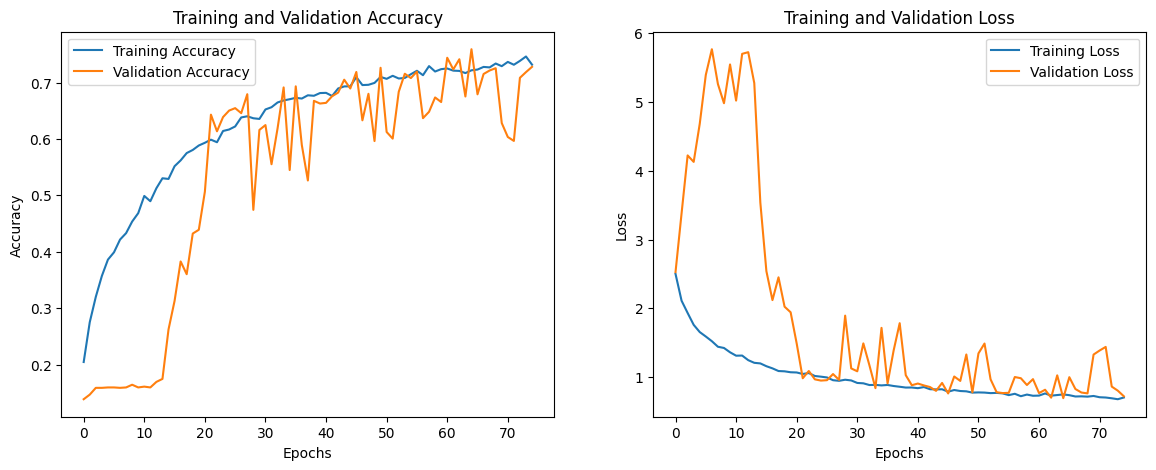

In [242]:
plot_training_history(classifier_fit)

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


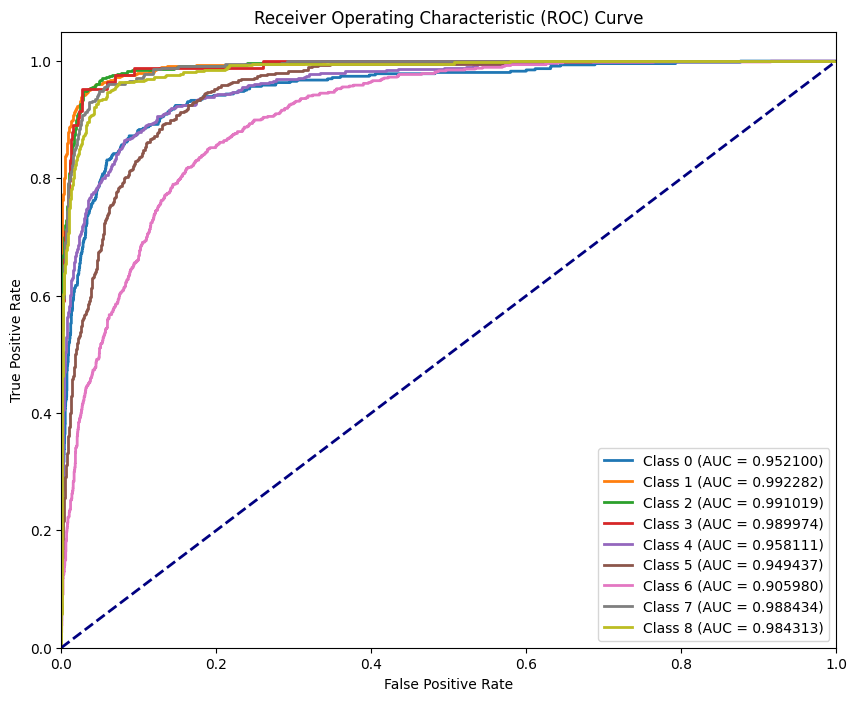

In [243]:
plot_roc_curve(X_test_std, y_test_enc, classifier_model)

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


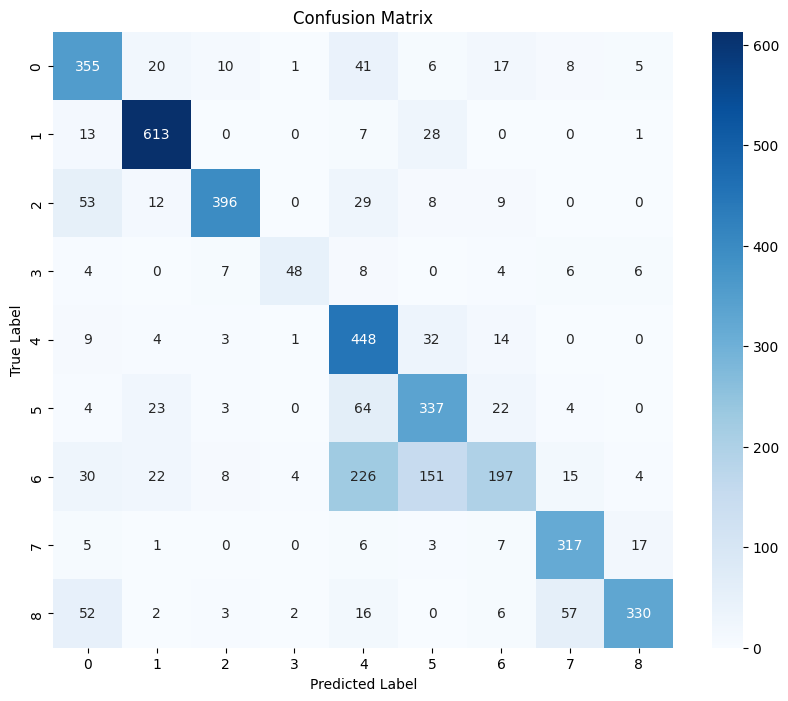

In [244]:
plot_confusion_matrix(X_test_std, y_test_enc, classifier_model)

## 3. Convolutional Autoencoder for anomaly detection

Steps:
- Train a convolutional autoencoder on **standard** train set only
- Plot training history
- Compute reconstruction loss (MSE) per image for:
  - Standard test set
  - Anomaly dataset (class 4)
- Plot histograms of reconstruction losses
- Use reconstruction loss as anomaly score and build ROC curve & confusion matrix (adapt provided code)

In [ ]:
# preprocess images by removing noise
import numpy as np
from astropy.stats import sigma_clipped_stats

# Function to subtract sky/noise and clipping mask
def subtract_sky_sigma_clipped_with_mask(images):
    N, H, W, C = images.shape
    reshaped = images.reshape(N, H*W, C)
    result = np.zeros_like(images)

    for c in range(C):
        # Median + Std
        mean, median, std = sigma_clipped_stats(reshaped[:, :, c], sigma=3.0, maxiters=5, axis=1)

        # Mask
        mask = reshaped[:, :, c] < (median[:, np.newaxis] + 5 * std[:, np.newaxis])

        # Ffinal sky
        sky_final = np.median(np.where(mask, reshaped[:, :, c], np.nan), axis=1)
        sky_final = np.nan_to_num(sky_final, nan=median)  # fallback

        result[:, :, :, c] = images[:, :, :, c] - sky_final[:, np.newaxis, np.newaxis]

    return result

X_train_reduced = subtract_sky_sigma_clipped_with_mask(X_train_std)
X_test_reduced = subtract_sky_sigma_clipped_with_mask(X_test_std)
X_val_reduced = subtract_sky_sigma_clipped_with_mask(X_val_std)
anomaly_images_reduced = subtract_sky_sigma_clipped_with_mask(anom_images)

# Visualize preprocessed galaxies
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
digits = [1,2,3,-1,-2]
for i, ax in enumerate(axes):
    ax.imshow(X_train_reduced[digits[i]])
    ax.set_title(f"Label: {y_train_std[digits[i]]}")
    ax.axis('off')
plt.show()

In [ ]:
# CAE model for standard dataset
cae_input = keras.Input((64, 64, 3))

# encoder
# first layer
x = layers.Conv2D(32, (3, 3), padding="same")(cae_input)
x = layers.BatchNormalization()(x)  # less dead neurons and vanaishing/exploding gradients
x = layers.Activation("relu")(x) # for more stable training (because of less dead neurons)
#x = layers.MaxPooling2D((2, 2))(x)  # get some sharper edges (especially for small spiral galaxy arms)
#x = layers.Dropout(0.1)(x)

x = layers.Conv2D(32, (3, 3), strides=2, padding="same")(x)
x = layers.Conv2D(32, (3, 3), strides=2, padding="same")(x)

# second layer
x = layers.Conv2D(32, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Dropout(0.1)(x)
encoder_output = layers.Flatten()(x)

# new representation space with bootleneck
x = layers.Dense(16*16*3)(encoder_output)
x = layers.Reshape((16, 16, 3))(x)

# decoder
# first decoder layer
x = layers.Conv2DTranspose(32, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
#x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)

# second decoder layer
x = layers.Conv2DTranspose(32, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
#x = layers.UpSampling2D((2, 2))(x)

cae_output = layers.Conv2D(3, (3, 3), padding="same", activation="sigmoid")(x)

# compile the model
cae_model = keras.Model(cae_input, cae_output, name="cae")

# compile the model
cae_model.compile(optimizer="adamW", loss="mse", metrics=["accuracy"])

# model summary
print(cae_model.summary())

In [ ]:
# Train model
cae_fit = cae_model.fit(
    X_train_reduced,
    X_train_reduced,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_reduced, X_val_reduced)
    )

In [ ]:
# plot training history
plt.plot(cae_fit.history['loss'], label='Train Loss')
plt.plot(cae_fit.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# reconstruct some images
X_out_test = cae_model.predict(X_test_reduced)
X_out_anom = cae_model.predict(anomaly_images_reduced)

# calculate MSE
mse_test = np.mean(np.square(X_test_std - X_out_test), axis=(1, 2, 3))
mse_anom = np.mean(np.square(anom_images - X_out_anom), axis=(1, 2, 3))

print(f"\nReconstruction loss (MSE) test set: {mse_test}")
print(f"\nReconstruction loss (MSE) anomaly set: {mse_anom}")


In [ ]:
# Visualize data set galaxies
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
digits = [1,2,3,-1,-2]
for i, ax in enumerate(axes):
    ax.imshow(X_test_reduced[digits[i]])
    ax.set_title(f"Label: {y_test_std[digits[i]]}")
    ax.axis('off')
plt.show()

In [ ]:
# Visualize reconstructed galaxies
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
digits = [1,2,3,-1,-2]
for i, ax in enumerate(axes):
    ax.imshow(X_out_test[digits[i]])
    ax.set_title(f"Label: {y_test_std[digits[i]]}")
    ax.axis('off')
plt.show()

In [ ]:
# Plot the distribution of MSE for normal vs anomalies
plt.figure(figsize=(10,6))
sns.histplot(mse_test, label='Normal', color='blue', kde=True)
sns.histplot(mse_anom, label='Anomalies', color='red', kde=True)
plt.title('MSE Distribution: Normal vs Anomalies')
plt.legend()
plt.show()

In [ ]:
# ROC curve
# combine normal and anomaly dataset
mse_all = np.concatenate([mse_test, mse_anom])
y_all = np.concatenate([np.zeros(len(mse_test)), np.ones(len(mse_anom))])

# compute ROC curve
fpr, tpr, thresholds = roc_curve(y_all, mse_all)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 4. Variational Autoencoder (VAE) on standard data

Steps:
- Build a VAE with convolutional encoder/decoder (trained on standard train set)
- Plot training history
- Generate new galaxy images from the VAE
- Visualize some generated images

In [ ]:
# Add Sampling class such that we have a possibility to differentiate in Training
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Define Encoder and Decoder
latent_dim = 128

# Encoder
encoder_inputs = keras.Input(shape=(64, 64, 3))

#first layer
x = layers.Conv2D(128, (3, 3), padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)  # less dead neurons and vanaishing/exploding gradients
x = layers.Activation("relu")(x) # for more stable training (because of less dead neurons)

# second layer
x = layers.Conv2D(128, (3, 3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)  # less dead neurons and vanaishing/exploding gradients
x = layers.Activation("relu")(x) # for more stable training (because of less dead neurons)
#x = layers.MaxPooling2D((2, 2))(x)  # get some sharper edges (especially for small spiral galaxy arms)

# third layer
x = layers.Conv2D(256, (3, 3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

# fourth layer
x = layers.Conv2D(256, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
#x = layers.MaxPooling2D((2, 2))(x)

# normal distribution space
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 256))(x)

# first decoder layer
x = layers.Conv2DTranspose(256, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
#x = layers.UpSampling2D((2, 2))(x)

# second decoder layer
x = layers.Conv2DTranspose(256, (3, 3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

# third layer
x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

# fourth layer
x = layers.Conv2DTranspose(3, (3, 3), padding="same")(x)
#x = layers.BatchNormalization()(x)
decoder_outputs = layers.Activation("sigmoid")(x)
#x = layers.UpSampling2D((2, 2))(x)

#decoder_outputs = layers.Conv2DTranspose(3, (3, 3), padding="same", activation="sigmoid")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

In [ ]:
# VAE Class
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # --------- MSE reconstruction loss ---------
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.mean_squared_error(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):

        z_mean, z_log_var, z = self.encoder(data, training=False)
        reconstruction = self.decoder(z, training=False)
            # --------- MSE reconstruction loss ---------
        reconstruction_loss = ops.mean(
            ops.sum(
                keras.losses.mean_squared_error(data, reconstruction),
                axis=(1, 2),
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }



In [ ]:
# construct the VAE model
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:
# training VAE model
vae_fit = vae.fit(X_train_std, epochs=30, batch_size=32, validation_data=X_val_std)

In [ ]:
# plot training history
plt.plot(vae_fit.history['loss'], label='Train Loss')
plt.plot(vae_fit.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def generate_random_images(decoder, latent_dim, n=10):
    # Sample random points in the latent space
    z_random = np.random.normal(size=(n, latent_dim))

    # Decode them into images
    generated = decoder.predict(z_random)

    # Plot
    plt.figure(figsize=(4*n, 8))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        img = generated[i].squeeze()
        plt.imshow(img)
        plt.axis("off")
    print(np.shape(generated))
    plt.show()

In [ ]:
# generate and visualize generated galaxy images
generate_random_images(decoder, latent_dim=latent_dim, n=4)